# Auto Encoder 구현
## Auto Encoder
- 비지도 학습 기법 중 하나
- 원본 데이터에서 특징을 추출하고 다시 원본을 생성하는 과정으로 진행된다.
- 원본 데이터와 생성된 데이터 사이의 차이가 작아지는 방향으로 학습
- encoder, decoder로 구성된다.
- encoder: 원본 데이터에서 특징을 추출하는 과정
- decoder: 특징을 사용하여 다시 데이터를 생성하는 과정
- 활용 분야: 중요 특징 학습, 이미지 노이즈 제거, 데이터 복원 등

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os
import sys
import gc

import torch
from torch import nn
import torchvision
import torchvision.transforms as T
from torchsummary import summary

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import wandb

In [2]:
# seed 고정
import random
import torch.backends.cudnn as cudnn

def random_seed(seed_num):
    torch.manual_seed(seed_num)
    torch.cuda.manual_seed(seed_num)
    torch.cuda.manual_seed_all(seed_num)
    np.random.seed(seed_num)
    cudnn.benchmark = False
    cudnn.deterministic = True
    random.seed(seed_num)

random_seed(42)

In [3]:
device = torch.device("mps")

## data

In [4]:
transforms = T.Compose([
    T.ToTensor()
])

download_root = './FASHION_MNIST_DATASET'
train_dataset = torchvision.datasets.FashionMNIST(root=download_root, train=True, download=True, transform=transforms)
test_dataset = torchvision.datasets.FashionMNIST(root=download_root, train=False, download=True, transform=transforms)

In [5]:
batch_size = 32

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

## AutoEncoder Model

In [6]:
class Autoencoder(torch.nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # Encoder: 원본 데이터에서 특징을 추출하는 과정
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(28*28, 128),
            torch.nn.ReLU(True),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(True),
            torch.nn.Linear(64, 12),
            torch.nn.ReLU(True),
            torch.nn.Linear(12, 3)
        )

        # Decoder: 추출된 특징을 사용하여 다시 데이터를 생성하는 과정
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(3, 12),
            torch.nn.ReLU(True),
            torch.nn.Linear(12, 64),
            torch.nn.ReLU(True),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(True),
            torch.nn.Linear(128, 28*28),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)  # 1차원 벡터로 변환
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return encoded, decoded

In [7]:
autoencoder = Autoencoder()

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

In [8]:
summary(autoencoder, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]         100,480
              ReLU-2                  [-1, 128]               0
            Linear-3                   [-1, 64]           8,256
              ReLU-4                   [-1, 64]               0
            Linear-5                   [-1, 12]             780
              ReLU-6                   [-1, 12]               0
            Linear-7                    [-1, 3]              39
            Linear-8                   [-1, 12]              48
              ReLU-9                   [-1, 12]               0
           Linear-10                   [-1, 64]             832
             ReLU-11                   [-1, 64]               0
           Linear-12                  [-1, 128]           8,320
             ReLU-13                  [-1, 128]               0
           Linear-14                  [

## train

In [9]:
def traininig(model, train_dataloader, criterion, optimizer):
    model.train()

    tbar = tqdm(train_dataloader)
    for images, labels in tbar:
        #images = images.to(device)
        #labels = labels.to(device)
        y = images.view(-1, 28*28)
        
        encoded, decoded = model(images)

        loss = criterion(decoded, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return model

In [10]:
#autoencoder = autoencoder.to(device)

for epoch in range(10):
    model = traininig(autoencoder, train_dataloader, criterion, optimizer)


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

## test

In [14]:
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model.eval()
total_images = []
total_decoded = []

with torch.no_grad():
    tbar = tqdm(test_dataloader)
    for images, labels in tbar:
        total_images.extend(images)
        encoded, decoded = model(images)
        total_decoded.extend(decoded)

  0%|          | 0/313 [00:00<?, ?it/s]

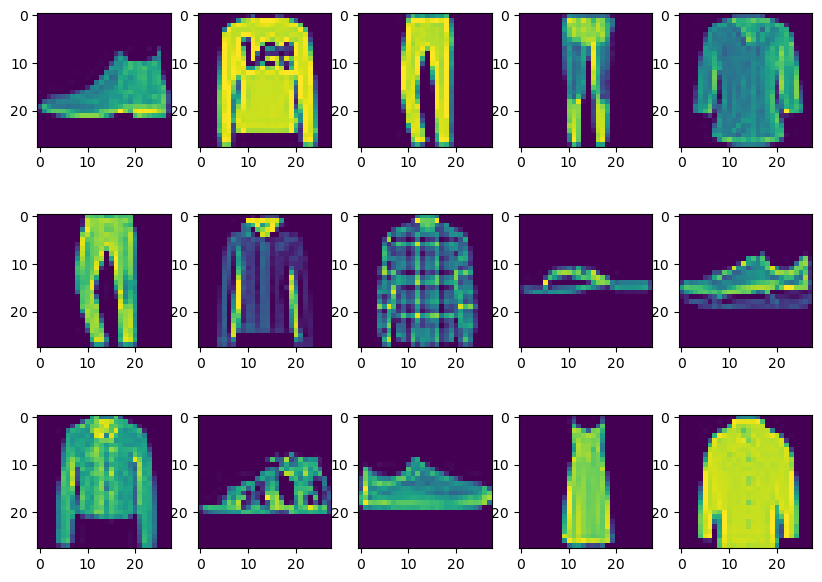

In [15]:
# 원본 데이터 출력

plt.figure(figsize=(10, 10))

for i in range(15):
    ax = plt.subplot(4, 5, i+1)
    plt.imshow(test_dataset[i][0].view(28, 28))

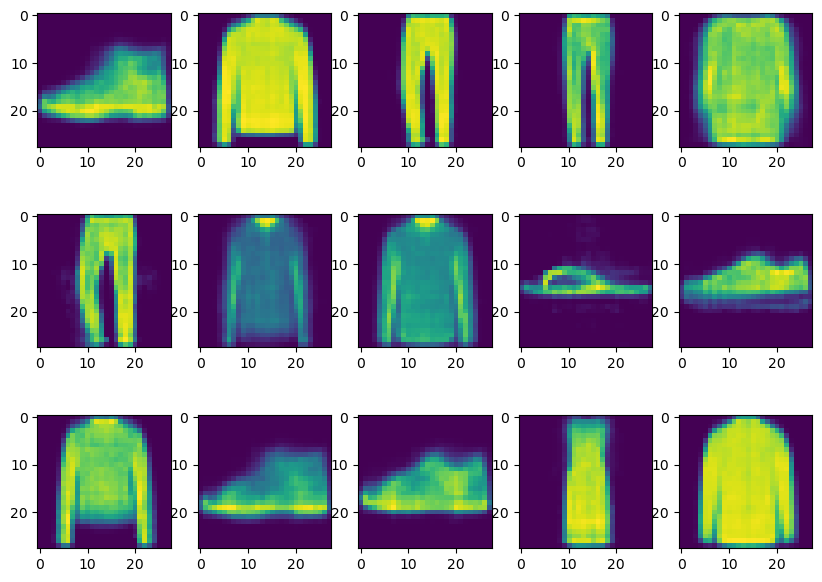

In [16]:
# 모델이 재생성한 데이터 출력

plt.figure(figsize=(10, 10))

for i in range(15):
    ax = plt.subplot(4, 5, i+1)
    plt.imshow(total_decoded[i].view(28, 28))